In [ ]:
library(coloc)
library(LDlinkR)
library(tidyverse)
library(data.table)
library(parallel)
library(GenomicRanges)
library(rtracklayer)
library(locuszoomr)
library(EnsDb.Hsapiens.v75)
library(ggpubr)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(gridExtra)
library(rjson)
library(cowplot)
library(patchwork)
library(locuszoomr)

In [3]:
## gene id-name map
gene_id_map = fread('../data/brain_eqtl/gene_id_name.allchrom.csv', sep='\t')

In [4]:
sorted_cell_types = c('Excitatory_neurons', 'Inhibitory_neurons', 'Astrocytes', 'Oligodendrocytes',
                     'Microglia', 'OPCs', 'Endothelial', 'Pericytes')

In [17]:
egenes_dict = fromJSON(file='../data/brain_data/merged_sumstats/by_chrom_gene/lowres_egenes_1e-05_truncorr_1e-10.json')

# Wnt signaling

In [18]:
gene_list = read.table('../data/brain_data/pathway_genes/neuron_Wnt.txt', header=FALSE)$V1
gene_list

[1] "WNT1"         "WNT2"         "WNT3"         "WNT5A"        "WNT7A"       
 [6] "WNT7B"        "WNT3A"        "WNT16"        "WNT4"         "WNT6"        
[11] "WNT10B"       "WNT11"        "WNT2B"        "WNT9B"        "WNT10A"      
[16] "WNT5B"        "FZD1"         "PORCN"        "WNT8A"        "WNT8B"       
[21] "WNT9A"        "CTNNB1"       "FZD2"         "LRP6"         "LRP5"        
[26] "FZD5"         "FZD4"         "FZD7"         "FZD8"         "FZD9"        
[31] "TMED5"        "VPS29"        "VPS35"        "WLS"          "SNX3"        
[36] "VPS26A"       "NPHP3-ACAD11" "DVL1"         "DVL2"         "DVL3"        
[41] "INVS"         "RHOA"         "MAPK8"        "MAPK9"        "MAPK10"      
[46] "FZD3"         "FZD6"         "FZD10"        "SOST"         "ROR2"        
[51] "DKK1"         "IGFBP4"       "ATP6AP2"      "RYK"          "RSPO1"       
[56] "CTHRC1"       "WIF1"         "JUN"          "CSNK1A1"      "CSNK1E"      
[61] "GSK3B"        "PPP2CA"       "PPP2CB"

In [19]:
all_ibsep_egene_ids = c()
all_sc_egene_ids = c()
for(ct in names(egenes_dict)){
    all_ibsep_egene_ids = c(all_ibsep_egene_ids, egenes_dict[[ct]][['SC-Brain-IBSEP']])
    all_sc_egene_ids = c(all_sc_egene_ids, egenes_dict[[ct]][['SC-Brain']])
}
all_ibsep_egene_ids = unique(all_ibsep_egene_ids)
all_sc_egene_ids = unique(all_sc_egene_ids)
print(length(all_ibsep_egene_ids))
print(length(all_sc_egene_ids))

[1] 6326
[1] 4825


In [20]:
all_ibsep_egenes = unname(sapply(all_ibsep_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
all_sc_egenes = unname(sapply(all_sc_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
print(length(all_ibsep_egenes))
print(length(all_sc_egenes))

[1] 6326
[1] 4825


In [21]:
## merge egenes with gene list
merged_ibsep_egenes = intersect(gene_list, all_ibsep_egenes)
merged_sc_egenes = intersect(gene_list, all_sc_egenes)
print(length(merged_ibsep_egenes))
print(length(merged_sc_egenes))

[1] 19
[1] 14


In [22]:
merged_ibsep_egenes

[1] "WNT3"   "WNT5A"  "WNT7A"  "WNT7B"  "WNT10B" "WNT2B"  "WNT8A"  "LRP6"  
 [9] "LRP5"   "FZD7"   "FZD9"   "TMED5"  "WLS"    "INVS"   "MAPK10" "FZD6"  
[17] "ROR2"   "RYK"    "CTHRC1"

In [26]:
intersect(merged_ibsep_egenes, merged_sc_egenes)
setdiff(merged_ibsep_egenes, merged_sc_egenes)
setdiff(merged_sc_egenes, merged_ibsep_egenes)

[1] "WNT7A"  "WNT7B"  "WNT2B"  "LRP6"   "LRP5"   "FZD7"   "FZD9"   "TMED5" 
 [9] "INVS"   "FZD6"   "ROR2"   "RYK"    "CTHRC1"

[1] "WNT3"   "WNT5A"  "WNT10B" "WNT8A"  "WLS"    "MAPK10"

[1] "MAPK9"

In [27]:
## with sign
# 1: shared, positive, 2: novel, positive
# -1: shared, negative, -2: novel, negative
merged_ibsep_sc_egenes = union(merged_ibsep_egenes,merged_sc_egenes)
mat = matrix(nrow=length(merged_ibsep_sc_egenes), ncol=length(sorted_cell_types))
for(i in 1:nrow(mat)){
    gene = merged_ibsep_sc_egenes[i]
    gene_id = gene_id_map[gene_id_map$GENENAME==gene]$GENEID
    gene_chr = gene_id_map[gene_id_map$GENENAME==gene]$CHR
    for(j in 1:ncol(mat)){
        ct = sorted_cell_types[j]
        filename = sprintf('../data/brain_data/merged_sumstats/by_chrom_gene/chr%s/%s_%s_IBSEP_truncorr_pval1e-10.csv', gene_chr, gene_id, ct)
        if(file.exists(filename)){
            eqtl_df = fread(filename, sep='\t') %>%
                dplyr::filter(!is.na(PVAL_BLUE)) %>%
                dplyr::filter(!is.na(PVAL))
            if((gene_id %in% egenes_dict[[ct]][['SC-Brain-IBSEP']]) & (gene_id %in% egenes_dict[[ct]][['SC-Brain']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 1, -1)
            }else if((gene_id %in% egenes_dict[[ct]][['SC-Brain-IBSEP']]) & !(gene_id %in% egenes_dict[[ct]][['SC-Brain']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 2, -2)
            }else if(!(gene_id %in% egenes_dict[[ct]][['SC-Brain-IBSEP']]) & (gene_id %in% egenes_dict[[ct]][['SC-Brain']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 3, -3)
            }else{
                mat[i, j] = 0
            }
        }else{
            mat[i, j] = 0
        }
    }
}

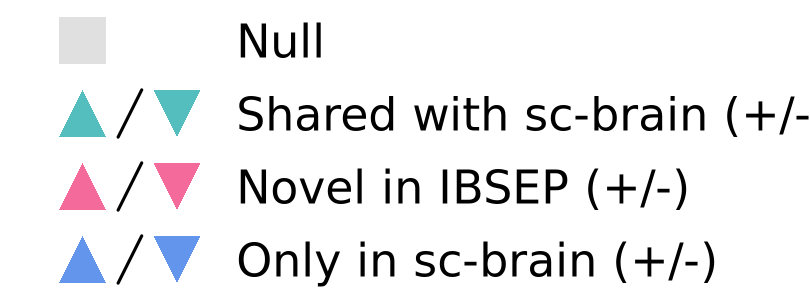

In [42]:
options(repr.plot.width=2.7, repr.plot.height=1, repr.plot.res=300)
c0 = "#E0E0E0"
c1 = '#54bebe'
c2 = '#f46a9b'
offset = 4
lgd = Legend(labels = c('Null', 'Shared with sc-brain (+/-)', 'Novel in IBSEP (+/-)', 'Only in sc-brain (+/-)'), 
             ncol=1, column_gap = unit(14, "mm"), row_gap = unit(2, 'mm'),
             legend_gp = gpar(fill = 'orange'),
             labels_gp = gpar(fontsize=11, fontfamily='ArialMT'), grid_width = unit(16, "mm"),
    graphics = list(
        function(x, y, w, h) grid.rect(unit(as.numeric(x)-4,'mm'), y, unit(4, 'mm'), unit(4, 'mm'), gp = gpar(fill = c0, col=NA)),
        function(x, y, w, h) {
            x1 = unit(as.numeric(x)-2-offset,'mm')
            x2 = unit(as.numeric(x)+2-offset,'mm')
            x3 = unit(as.numeric(x)-offset,'mm')
            y1 = unit(as.numeric(y)-2,'mm')
            y2 = unit(as.numeric(y)-2,'mm')
            y3 = unit(as.numeric(y)+2,'mm')
            grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), 
                         default.units='mm', gp = gpar(fill = c1, col=NA))
            x1 = unit(as.numeric(x)+3-offset,'mm')
            x2 = unit(as.numeric(x)+5-offset,'mm')
            y1 = unit(as.numeric(y)-2,'mm')
            y2 = unit(as.numeric(y)+2,'mm')
            grid.lines(x=c(x1,x2), y=c(y1,y2), default.units='mm')
            x1 = unit(as.numeric(x)+6-offset,'mm')
            x2 = unit(as.numeric(x)+10-offset,'mm')
            x3 = unit(as.numeric(x)+8-offset,'mm')
            y1 = unit(as.numeric(y)+2,'mm')
            y2 = unit(as.numeric(y)+2,'mm')
            y3 = unit(as.numeric(y)-2,'mm')
            grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), 
                         default.units='mm', gp = gpar(fill = c1, col=NA))
        },
        function(x, y, w, h) {
            x1 = unit(as.numeric(x)-2-offset,'mm')
            x2 = unit(as.numeric(x)+2-offset,'mm')
            x3 = unit(as.numeric(x)-offset,'mm')
            y1 = unit(as.numeric(y)-2,'mm')
            y2 = unit(as.numeric(y)-2,'mm')
            y3 = unit(as.numeric(y)+2,'mm')
            grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), 
                         default.units='mm', gp = gpar(fill = c2, col=NA))
            x1 = unit(as.numeric(x)+3-offset,'mm')
            x2 = unit(as.numeric(x)+5-offset,'mm')
            y1 = unit(as.numeric(y)-2,'mm')
            y2 = unit(as.numeric(y)+2,'mm')
            grid.lines(x=c(x1,x2), y=c(y1,y2), default.units='mm')
            x1 = unit(as.numeric(x)+6-offset,'mm')
            x2 = unit(as.numeric(x)+10-offset,'mm')
            x3 = unit(as.numeric(x)+8-offset,'mm')
            y1 = unit(as.numeric(y)+2,'mm')
            y2 = unit(as.numeric(y)+2,'mm')
            y3 = unit(as.numeric(y)-2,'mm')
            grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), 
                         default.units='mm', gp = gpar(fill = c2, col=NA))
        },
        function(x, y, w, h) {
            x1 = unit(as.numeric(x)-2-offset,'mm')
            x2 = unit(as.numeric(x)+2-offset,'mm')
            x3 = unit(as.numeric(x)-offset,'mm')
            y1 = unit(as.numeric(y)-2,'mm')
            y2 = unit(as.numeric(y)-2,'mm')
            y3 = unit(as.numeric(y)+2,'mm')
            grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), 
                         default.units='mm', gp = gpar(fill = c3, col=NA))
            x1 = unit(as.numeric(x)+3-offset,'mm')
            x2 = unit(as.numeric(x)+5-offset,'mm')
            y1 = unit(as.numeric(y)-2,'mm')
            y2 = unit(as.numeric(y)+2,'mm')
            grid.lines(x=c(x1,x2), y=c(y1,y2), default.units='mm')
            x1 = unit(as.numeric(x)+6-offset,'mm')
            x2 = unit(as.numeric(x)+10-offset,'mm')
            x3 = unit(as.numeric(x)+8-offset,'mm')
            y1 = unit(as.numeric(y)+2,'mm')
            y2 = unit(as.numeric(y)+2,'mm')
            y3 = unit(as.numeric(y)-2,'mm')
            grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), 
                         default.units='mm', gp = gpar(fill = c3, col=NA))
        }
    ))
draw(lgd)

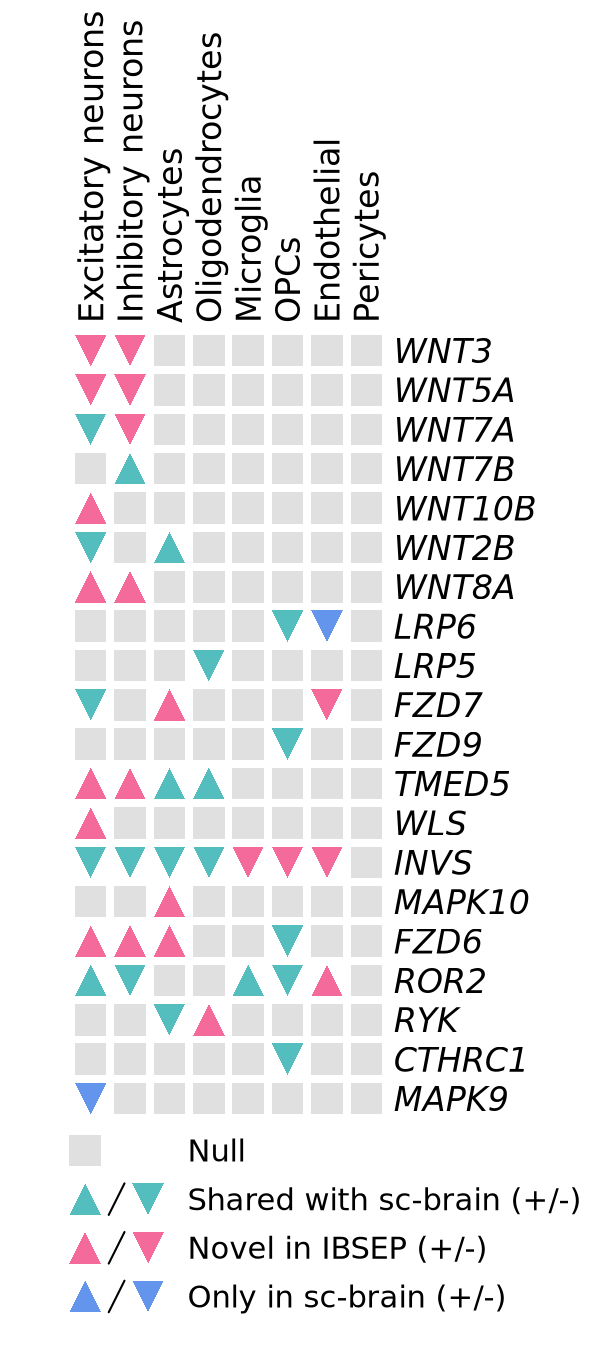

In [43]:
## with sc only
options(repr.plot.width=3, repr.plot.height=6.8, repr.plot.res=200)

# c1 = "#F58383"
# c2 = "#FBB46F"
c0 = "#E0E0E0"
c1 = '#54bebe'
c2 = '#f46a9b'
c3 = '#6495ED' # only in sc
col_fun = colorRamp2(c(0, 1, 2, 3), c(c0, c1, c2, c3))
colors = structure(c(c0, c1, c2, c3), names = c(0,1,2,3))
w = ncol(mat)*unit(5, "mm")
h = nrow(mat)*unit(5, "mm")
ht = Heatmap(mat, col = colors, rect_gp = gpar(type = "none"),
        cluster_rows = FALSE, cluster_columns = FALSE,
        cell_fun = function(j, i, x, y, width, height, fill) {
            if(mat[i, j]==0){
                grid.rect(x=x, y=y, width=unit(4, 'mm'), height=unit(4, 'mm'),
                         gp = gpar(fill = c0, col = NA))
                # grid.circle(x = x, y = y, r = unit(2, "mm"), 
                # gp = gpar(fill = '#E0E0E0', col = NA))
            }else if(mat[i, j]>0){
                x1 = unit(as.numeric(x)*as.numeric(w)-2,'mm')
                x2 = unit(as.numeric(x)*as.numeric(w)+2,'mm')
                x3 = unit(as.numeric(x)*as.numeric(w),'mm')
                y1 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                y2 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                y3 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                # message(sprintf('(%s, %s), (%s, %s), (%s, %s)', x1, y1, x2, y2, x3, y3))
                grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), default.units='mm',
                             gp = gpar(fill = col_fun(abs(mat[i, j])), col = NA))
            }else if(mat[i, j]<0){
                x1 = unit(as.numeric(x)*as.numeric(w)-2,'mm')
                x2 = unit(as.numeric(x)*as.numeric(w)+2,'mm')
                x3 = unit(as.numeric(x)*as.numeric(w),'mm')
                y1 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                y2 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                y3 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                # message(sprintf('(%s, %s), (%s, %s), (%s, %s)', x1, y1, x2, y2, x3, y3))
                grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), default.units='mm',
                             gp = gpar(fill = col_fun(abs(mat[i, j])), col = NA))
            }
           },
        right_annotation=rowAnnotation(labels = anno_text(merged_ibsep_sc_egenes, which='row', 
                                                          gp = gpar(fontsize = 12, fontfamily='ArialMT', fontface = "italic"))),
        top_annotation=columnAnnotation(labels = anno_text(sapply(sorted_cell_types, function(x){gsub('_', ' ', x)}), 
                                                              which='column', gp = gpar(fontsize = 12, fontfamily='ArialMT'),
                                                          just='left', location=unit(0, 'npc'))),
        width = w, height = h, column_gap = unit(0, "mm"), border = FALSE, show_column_names=TRUE,
        show_heatmap_legend=FALSE
        )
# draw(ht) annotation_legend_side = "bottom"
draw(ht, annotation_legend_list = lgd, annotation_legend_side = "bottom")

## Locuszoom

In [61]:
gene = 'TMED5'
gene_id = gene_id_map[gene_id_map$GENENAME==gene]$GENEID
gene_chr = gene_id_map[gene_id_map$GENENAME==gene]$CHR
gene_chr
gene_id

[1] 1

[1] "ENSG00000117500"

In [62]:
ct = 'Excitatory_neurons'
eqtl_df = fread(sprintf('../data/brain_data/merged_sumstats/by_chrom_gene/chr%s/%s_%s_IBSEP_truncorr_pval1e-10.csv', 
                        gene_chr, gene_id, ct), sep='\t') %>%
            dplyr::filter(!is.na(PVAL_BLUE)) %>%
            dplyr::filter(!is.na(PVAL))

In [52]:
ct = 'Inhibitory_neurons'
eqtl_df = fread(sprintf('../data/brain_data/merged_sumstats/by_chrom_gene/chr%s/%s_%s_IBSEP_truncorr_pval1e-10.csv', 
                        gene_chr, gene_id, ct), sep='\t') %>%
            dplyr::filter(!is.na(PVAL_BLUE)) %>%
            dplyr::filter(!is.na(PVAL))

In [33]:
min(eqtl_df$BP)
max(eqtl_df$BP)
eqtl_df$CHR[1]

[1] 43910653

[1] 45909183

[1] 17

In [64]:
# TMED5: c(92600000, 94700000), 1
# WNT3: c(43900000, 46000000), 17
loc_eqtl <- locus(data=eqtl_df, chrom='CHR', pos='BP', p='PVAL', xrange=c(92600000, 94700000), seqname=1, ens_db = "EnsDb.Hsapiens.v75")
loc_eqtl <- link_LD(loc_eqtl, token = "7be0fab0c5d8")

chromosome 1, position 92600000 to 94700000

2965 SNPs/datapoints

Obtaining LD on 1000 SNPs


In [65]:
loc_ibsep <- locus(data=eqtl_df, chrom='CHR', pos='BP', p='PVAL_BLUE', xrange=c(92600000, 94700000), seqname=1, ens_db = "EnsDb.Hsapiens.v75")
loc_ibsep <- link_LD(loc_ibsep, token = "7be0fab0c5d8")

chromosome 1, position 92600000 to 94700000

2965 SNPs/datapoints

Obtaining LD on 1000 SNPs


In [60]:
loc_eqtl$index_snp
loc_ibsep$index_snp

[1] "rs4424943"

[1] "rs9904865"

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
8 tracks needed to show all genes



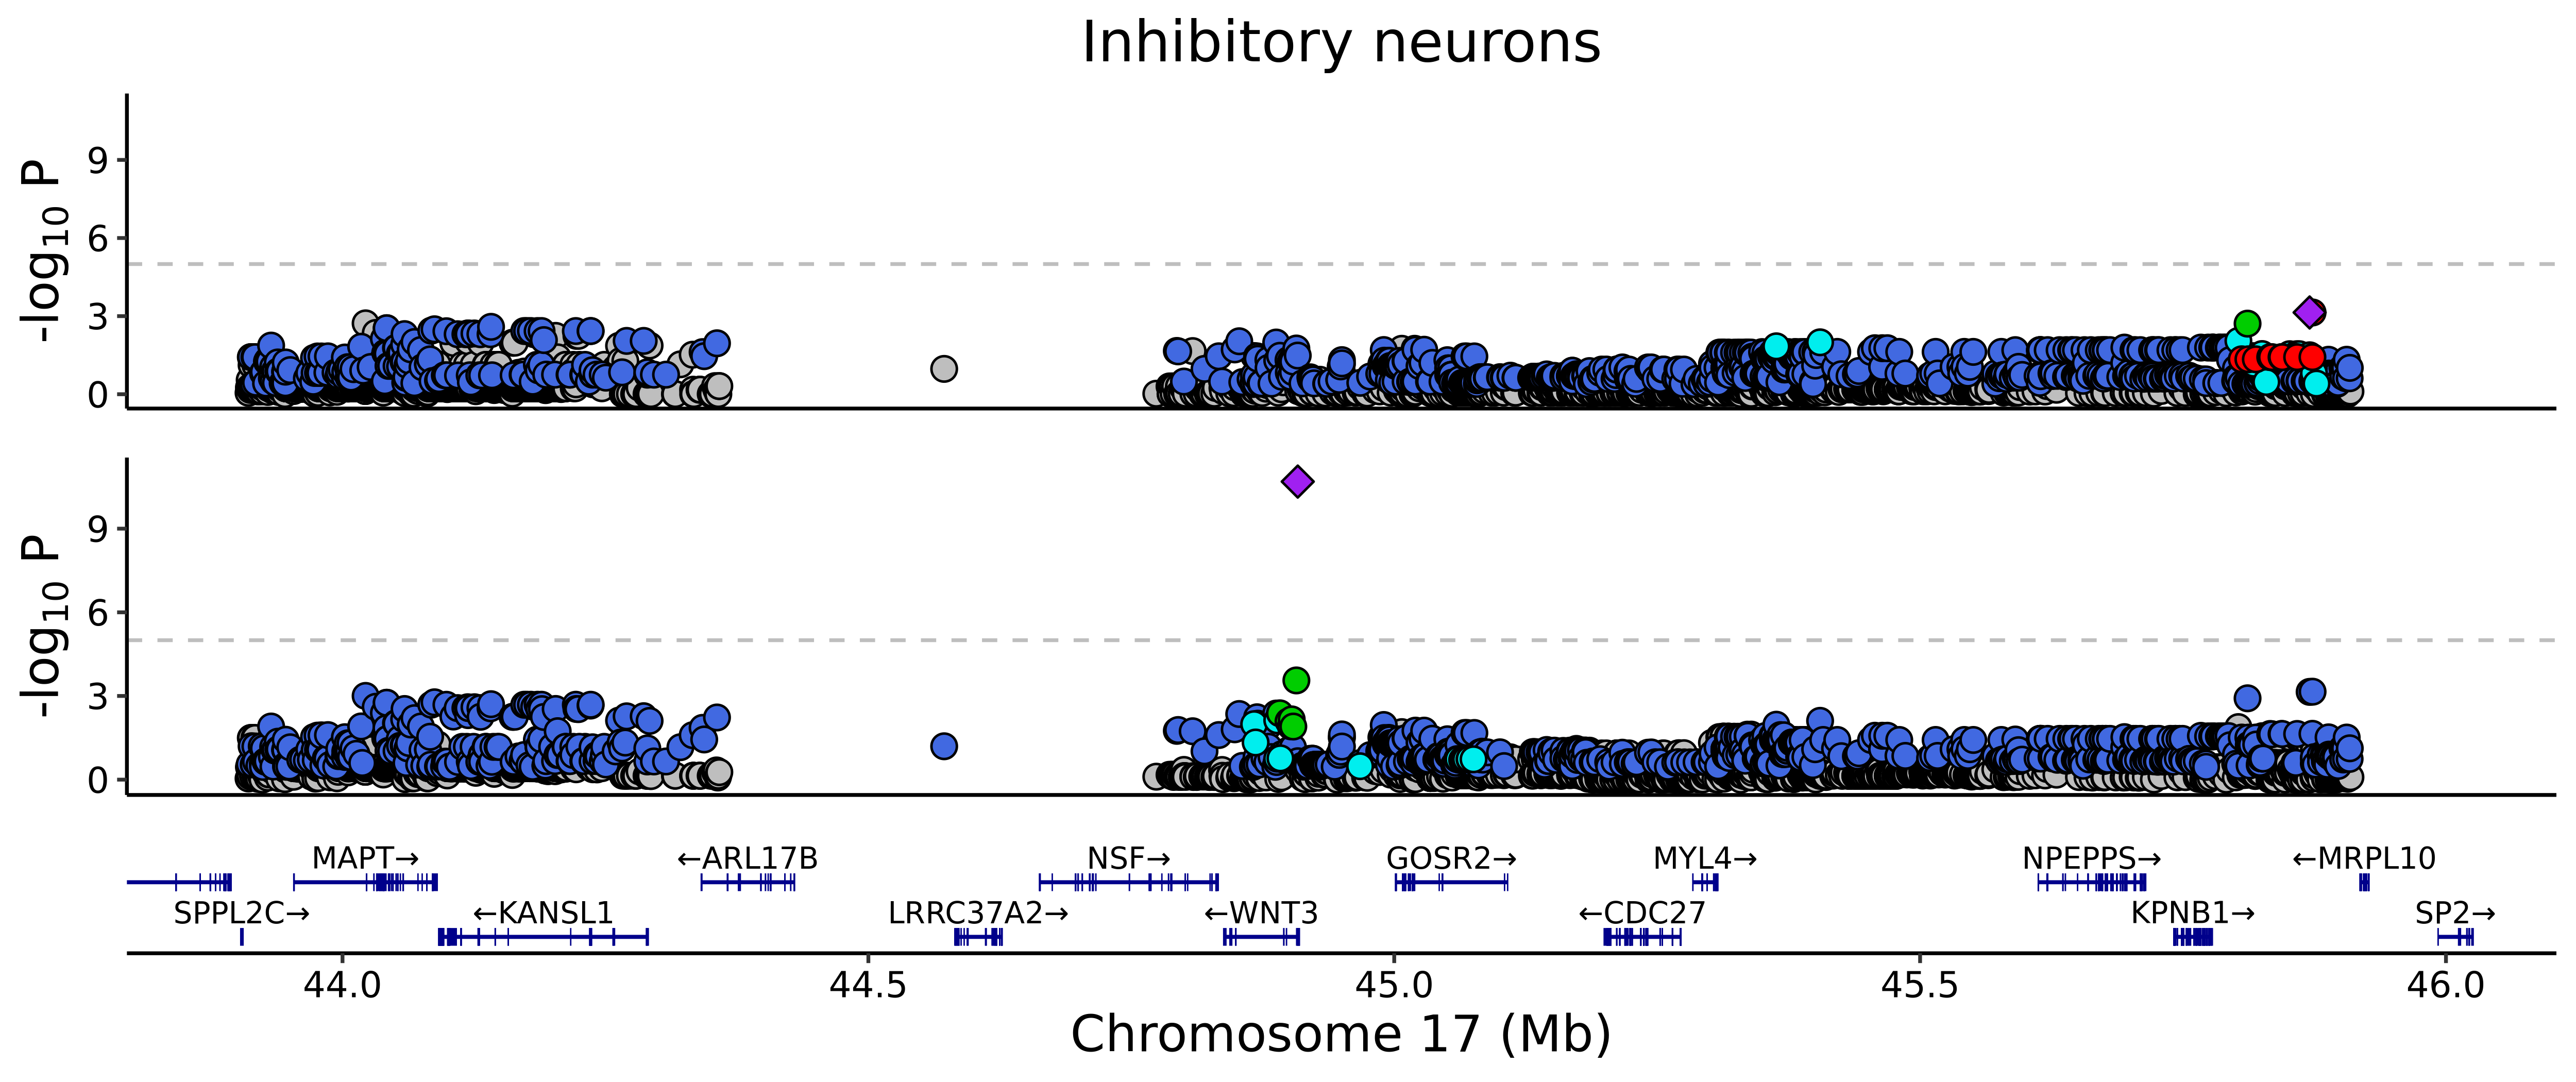

In [58]:
## WNT3
options(repr.plot.width=10, repr.plot.height=4.2, repr.plot.res=500)
ymax = 11
ymax2 = 30
ycut = 5
s = 3
p1 <- gg_scatter(loc_eqtl, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) + ggtitle('Inhibitory neurons') + 
    ylim(c(0, ymax)) + geom_hline(yintercept = ycut, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=10), axis.title=element_text(size=14), plot.title = element_text(color="black", size=16, hjust=0.5),
          legend.text=element_text(size=10), legend.title=element_text(size=14), legend.background=element_rect(fill = alpha("white", 0.0)))
p2 <- gg_scatter(loc_ibsep, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) + ylim(c(0, ymax)) + 
    theme(axis.text=element_text(size=10), axis.title=element_text(size=14),
         legend.text=element_text(size=10), legend.title=element_text(size=14), legend.background=element_rect(fill = alpha("white", 0.0)))
g <- gg_genetracks(loc_ibsep, maxrows=2, filter_gene_biotype='protein_coding') + 
    theme(axis.text.x=element_text(size=10), axis.title.x=element_text(size=14))

plot_grid(p1, p2, g, ncol = 1, rel_heights = c(1.7, 1.5, 1), align = "v")

In [66]:
loc_eqtl$index_snp
loc_ibsep$index_snp

[1] "rs3120133"

[1] "rs6701250"

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
4 tracks needed to show all genes



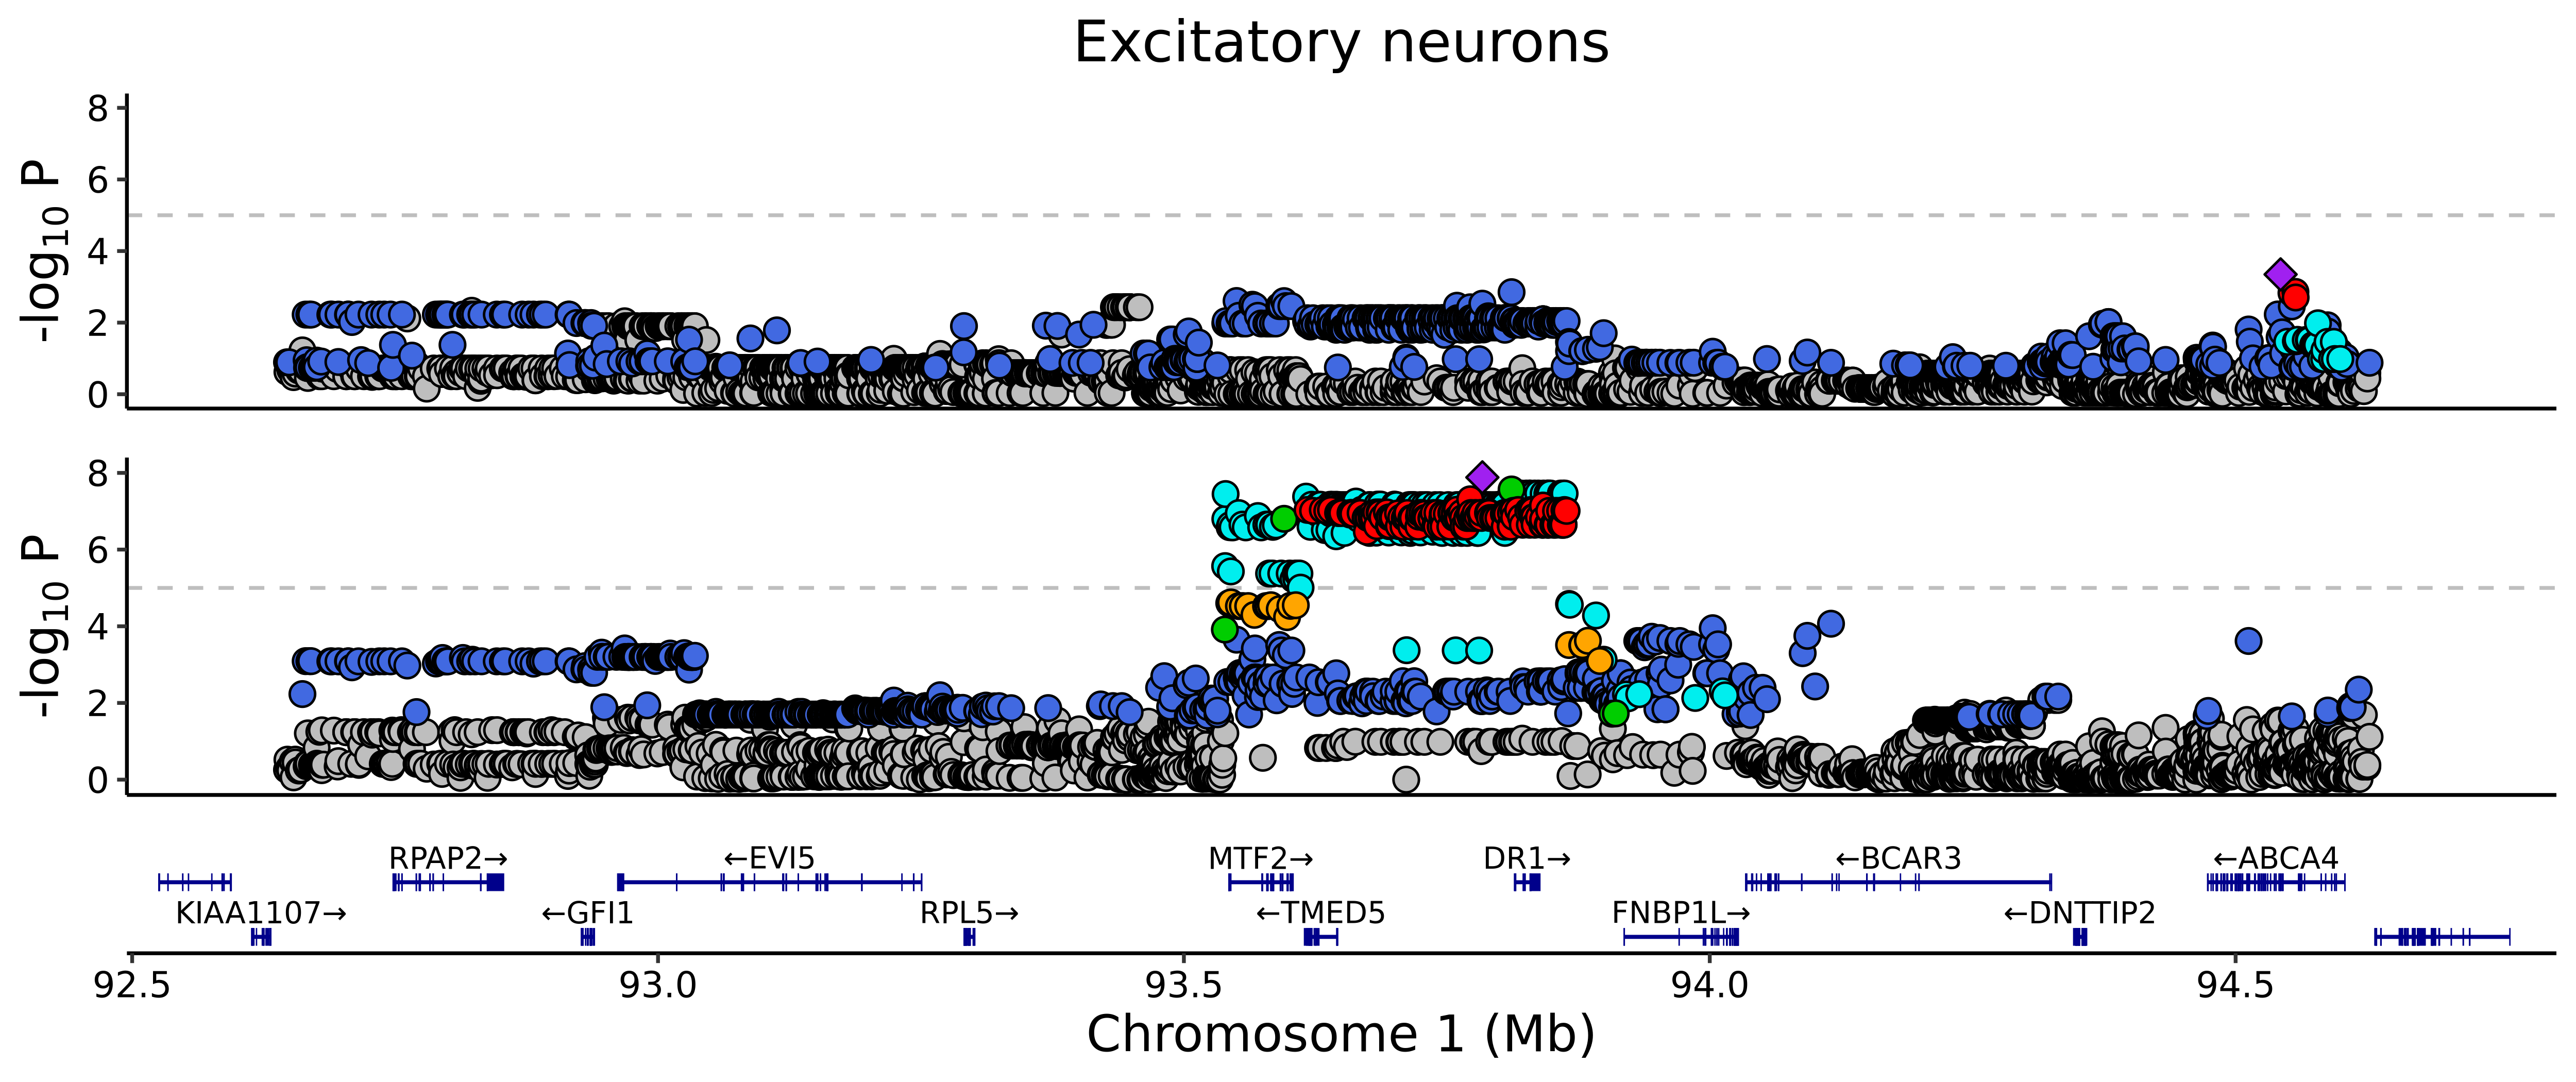

In [67]:
## TMED5
options(repr.plot.width=10, repr.plot.height=4.2, repr.plot.res=500)
ymax = 8
ymax2 = 30
ycut = 5
s = 3
p1 <- gg_scatter(loc_eqtl, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) + ggtitle('Excitatory neurons') + 
    ylim(c(0, ymax)) + geom_hline(yintercept = ycut, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=10), axis.title=element_text(size=14), plot.title = element_text(color="black", size=16, hjust=0.5),
          legend.text=element_text(size=10), legend.title=element_text(size=14), legend.background=element_rect(fill = alpha("white", 0.0)))
p2 <- gg_scatter(loc_ibsep, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) + ylim(c(0, ymax)) + 
    theme(axis.text=element_text(size=10), axis.title=element_text(size=14),
         legend.text=element_text(size=10), legend.title=element_text(size=14), legend.background=element_rect(fill = alpha("white", 0.0)))
g <- gg_genetracks(loc_ibsep, maxrows=2, filter_gene_biotype='protein_coding') + 
    theme(axis.text.x=element_text(size=10), axis.title.x=element_text(size=14))

plot_grid(p1, p2, g, ncol = 1, rel_heights = c(1.7, 1.5, 1), align = "v")

# Upset plot (egene)

In [6]:
egenes_dict = fromJSON(file='../data/brain_data/merged_sumstats/by_chrom_gene/lowres_egenes_1e-05_truncorr_1e-10.json')

In [7]:
lt_sc = lapply(egenes_dict, function(x) x$`SC-Brain`)
lt_ibsep = lapply(egenes_dict, function(x) x$`SC-Brain-IBSEP`)

In [8]:
## comb mat
n_keep = 20
m_sc_ori = make_comb_mat(lt_sc)
m_ibsep_ori = make_comb_mat(lt_ibsep)
m_sc = m_sc_ori[,rev(order(comb_size(m_sc_ori)))[1:n_keep]]
m_ibsep = m_ibsep_ori[,rev(order(comb_size(m_ibsep_ori)))[1:n_keep]]

In [9]:
## comb reorder
ibsep_size_ori = comb_size(m_ibsep_ori)
sc_size_ori = comb_size(m_sc_ori)
ibsep_size_order = rev(order(ibsep_size_ori))[1:n_keep]
ibsep_order = ibsep_size_ori[ibsep_size_order]
sc_order = sc_size_ori[names(ibsep_size_ori)[ibsep_size_order]]

In [10]:
## set reorder
ibsep_set_ori = set_size(m_ibsep_ori)
sc_set_ori = set_size(m_sc_ori)
ibsep_set_order = rev(order(ibsep_set_ori))
sc_set_order = sc_set_ori[names(ibsep_set_ori)[ibsep_set_order]]
ibsep_set_order = ibsep_set_ori[ibsep_set_order]
m_ibsep = m_ibsep[names(ibsep_set_order),]
ibsep_set_order
sc_set_order

Excitatory_neurons   Oligodendrocytes         Astrocytes Inhibitory_neurons 
              3644               2431               2247               1974 
              OPCs          Microglia        Endothelial          Pericytes 
              1372               1022                910                449

Excitatory_neurons   Oligodendrocytes         Astrocytes Inhibitory_neurons 
              2307               1669               1072                987 
              OPCs          Microglia        Endothelial          Pericytes 
               738                597                370                164

In [11]:
rownames(m_ibsep) = unname(sapply(rownames(m_ibsep), function(x) gsub('_', ' ', x)))

In [12]:
m_ibsep

Excitatory neurons,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,1,1,1,0,0
Oligodendrocytes,0,1,0,0,1,0,0,0,0,1,0,1,1,0,1,1,0,0,0,1
Astrocytes,0,0,1,0,0,0,1,0,0,1,0,0,1,1,1,1,0,0,1,0
Inhibitory neurons,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0,0
OPCs,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1,1
Microglia,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Endothelial,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Pericytes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
options(repr.plot.width=11, repr.plot.height=6.5, repr.plot.res=300)
ht_opt(ANNOTATION_LEGEND_PADDING = unit(6, 'mm'))
c_ibsep = '#A89DD9'
c_sc = '#A0C668'
alpha = 1
w = ncol(m_ibsep)*unit(8, "mm")
h = nrow(m_ibsep)*unit(8, "mm")
barw = 0.8
label_font = 14
axis_font = 10
upset = UpSet(m_ibsep, set_order = rev(order(set_size(m_ibsep))), comb_order = rev(order(comb_size(m_ibsep))),
     top_annotation = columnAnnotation('Number of eGenes'=anno_barplot(cbind(ibsep_order, sc_order), gp = gpar(fill = c(c_ibsep, c_sc), alpha=alpha), 
                                                         border=FALSE, axis=TRUE, beside = TRUE, attach = TRUE, bar_width = barw,
                                                                      axis_param=list(side='left', labels_rot = 0, gp=gpar(fontsize = axis_font))),
                                       height=unit(80, 'mm'), annotation_name_side='left', annotation_name_offset=unit(13, 'mm'),
                                      annotation_name_gp= gpar(fontsize = label_font)),
     right_annotation = rowAnnotation('Total eGenes'=anno_barplot(cbind(ibsep_set_order, sc_set_order), gp = gpar(fill = c(c_ibsep, c_sc)),
                                                           border=FALSE, axis=TRUE, beside = TRUE, attach = TRUE, bar_width = barw,
                                                      axis_param=list(side='bottom', labels_rot = 0, gp=gpar(fontsize = axis_font))),
                                          width=unit(60, 'mm'), annotation_name_offset=unit(8, 'mm'),
                                     annotation_name_gp= gpar(fontsize = label_font)),
     row_names_gp = gpar(fontsize = 14, fontfamily='ArialMT'),
     width = w, height = h, show_row_names=TRUE)
lgd = Legend(labels = c('IBSEP', 'sc-Brain'), nrow=1, , column_gap = unit(10, "mm"), 
             labels_gp = gpar(fontsize=12, fontfamily='ArialMT'), grid_width = unit(6, "mm"),
             graphics = list(
                 function(x, y, w, h) grid.rect(x, y, unit(4, 'mm'), unit(4, 'mm'), gp = gpar(fill = c_ibsep, col=NA)),
                 function(x, y, w, h) grid.rect(x, y, unit(4, 'mm'), unit(4, 'mm'), gp = gpar(fill = c_sc, col=NA))))

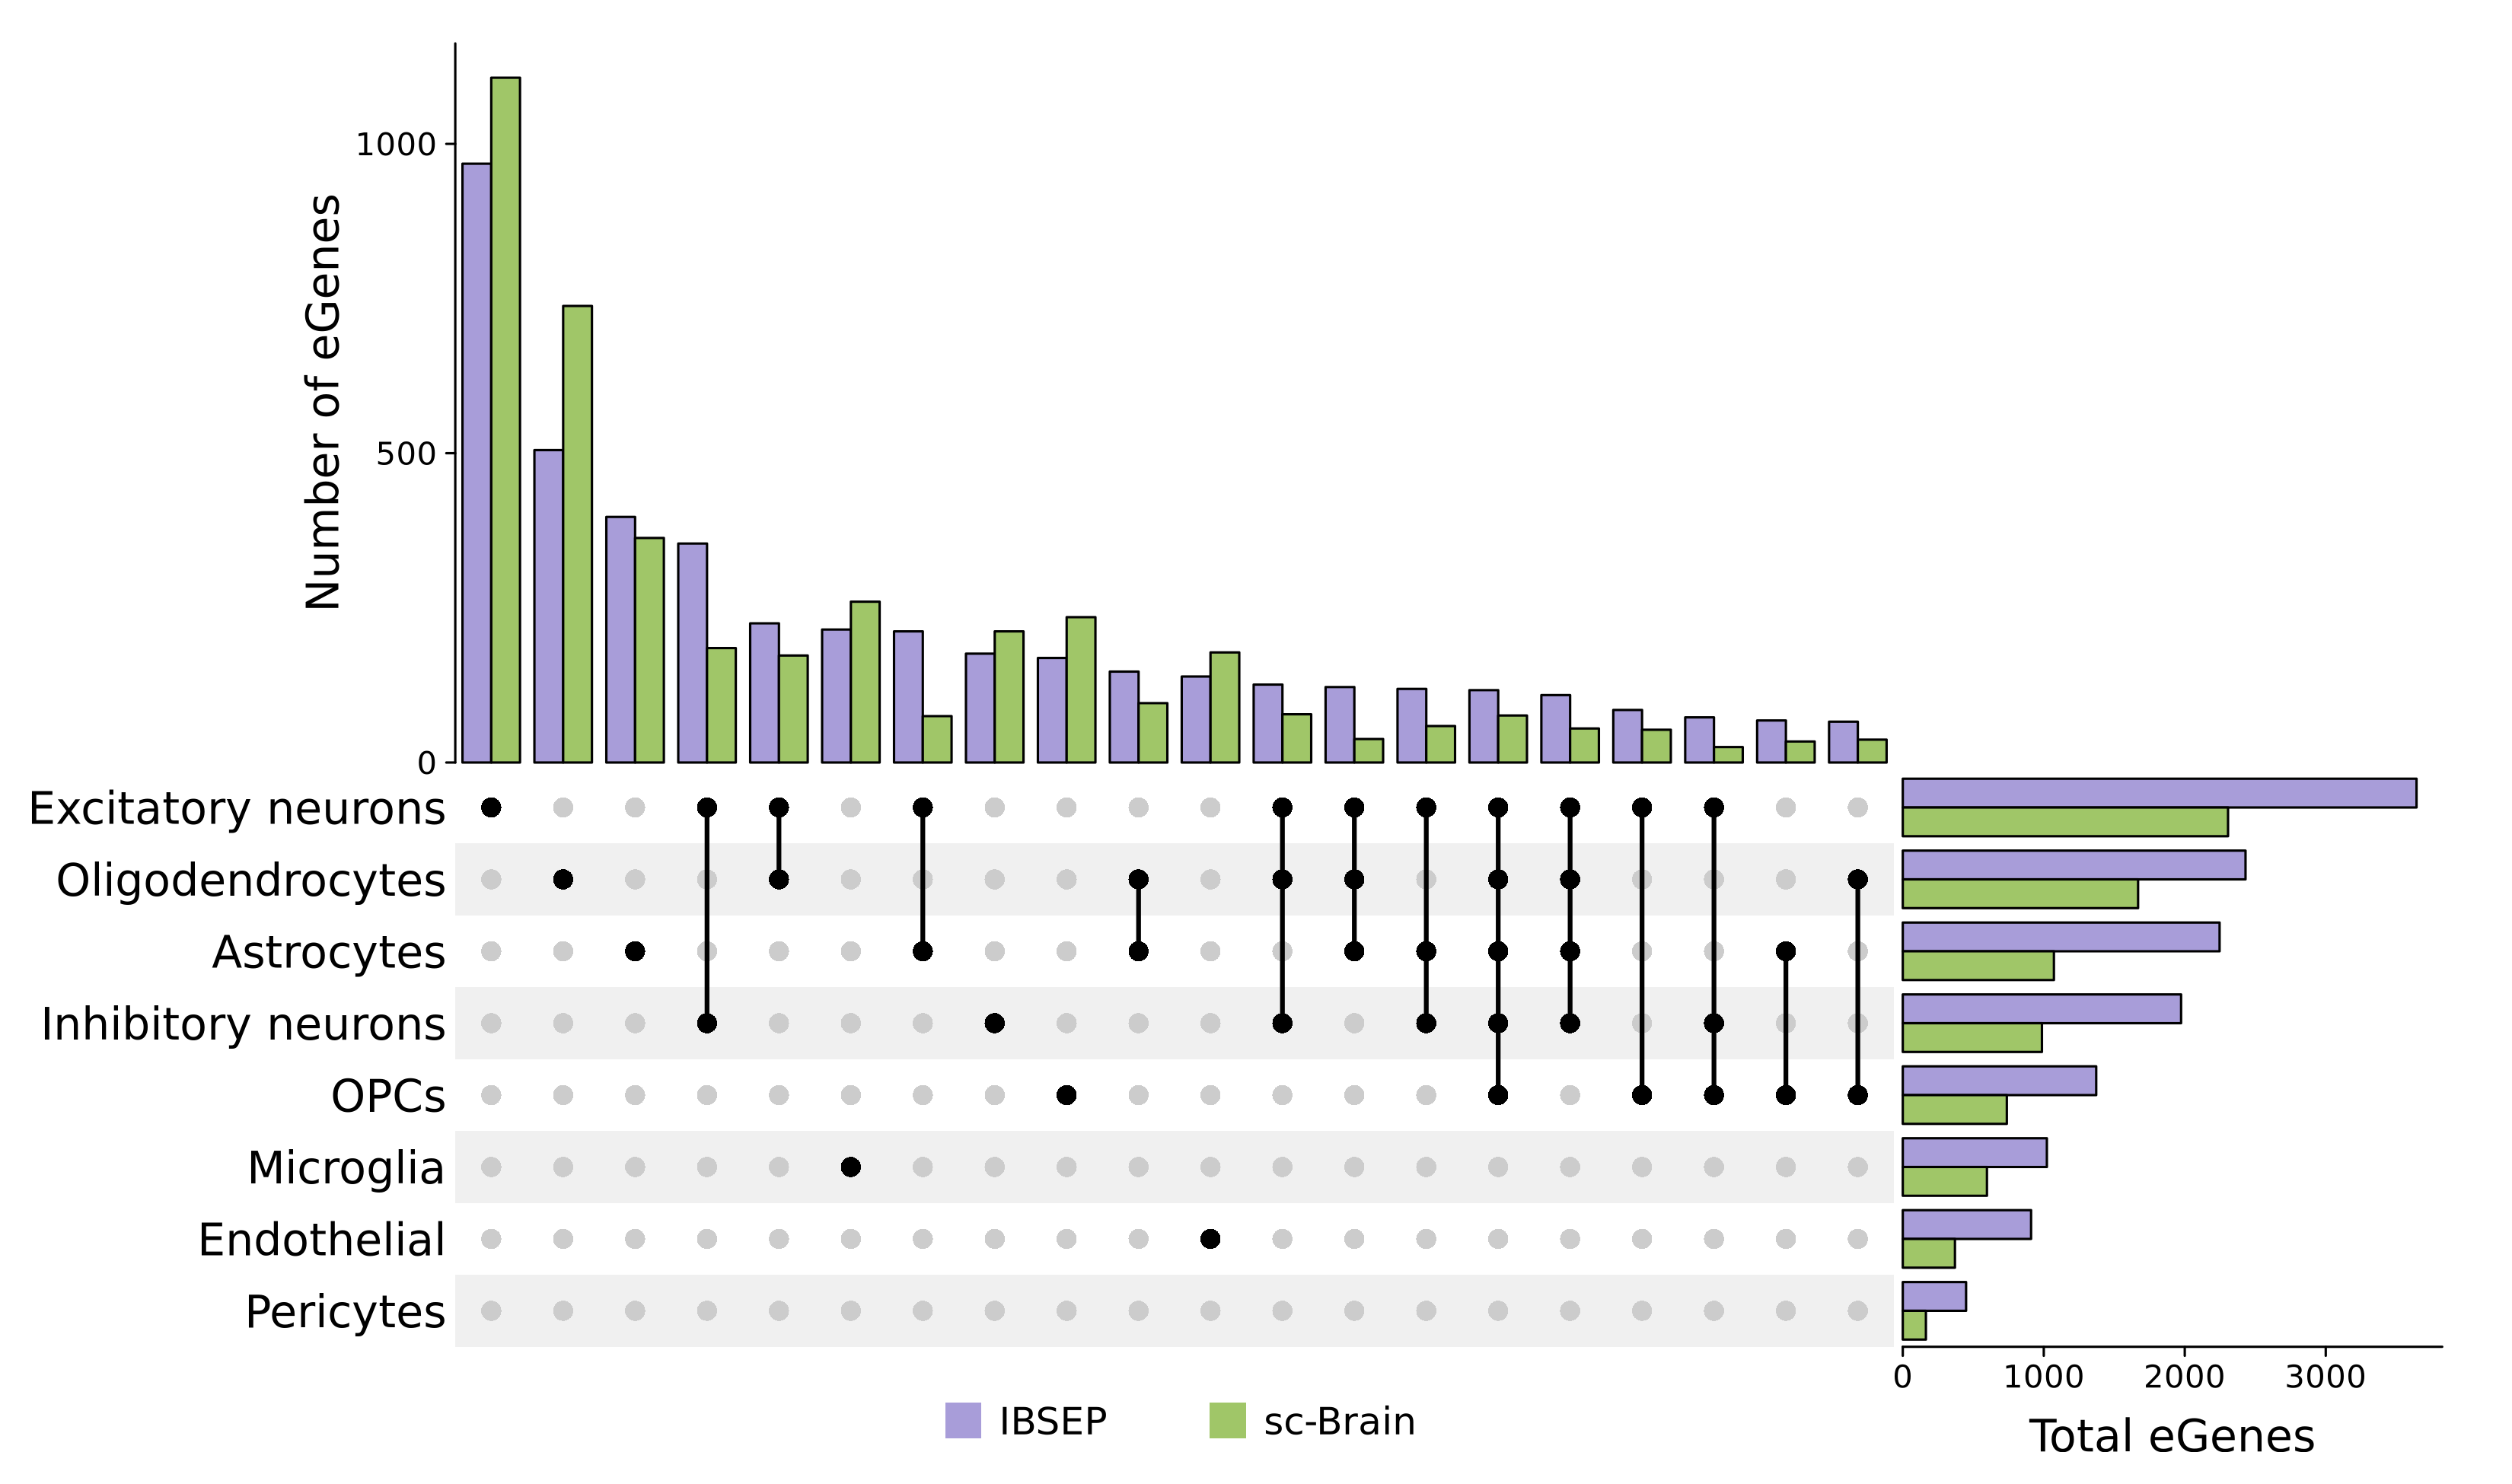

In [14]:
draw(upset, annotation_legend_list = lgd, annotation_legend_side = "bottom")